# **Data transformation**
**Dataset Summary**

The Belgian Statutory Article Retrieval Dataset (BSARD) is a French native dataset for studying legal information retrieval. BSARD consists of more than 22,600 statutory articles from Belgian law and about 1,100 legal questions posed by Belgian citizens and labeled by experienced jurists with relevant articles from the corpus.

The text in the dataset is in French, as spoken in Wallonia and Brussels-Capital region. The associated BCP-47 code is fr-BE.

The dataset was created mainly for document-retrieval: The dataset can be used to train models for ad-hoc legal information retrieval. Such model is presented with a short user query written in natural language and asked to retrieve relevant legal information from a knowledge source (such as statutory articles).


**My approach**

Instead of using the dataset to do legal document retrieval i decided that i transform it to make it into an NLI dataset with the "questions" feature as a premise and create my own hypothesis for each question by using it's "category". This allows me to classify the questions into their categories by turning an NLI problem to a classification one using the zero-shot approach.

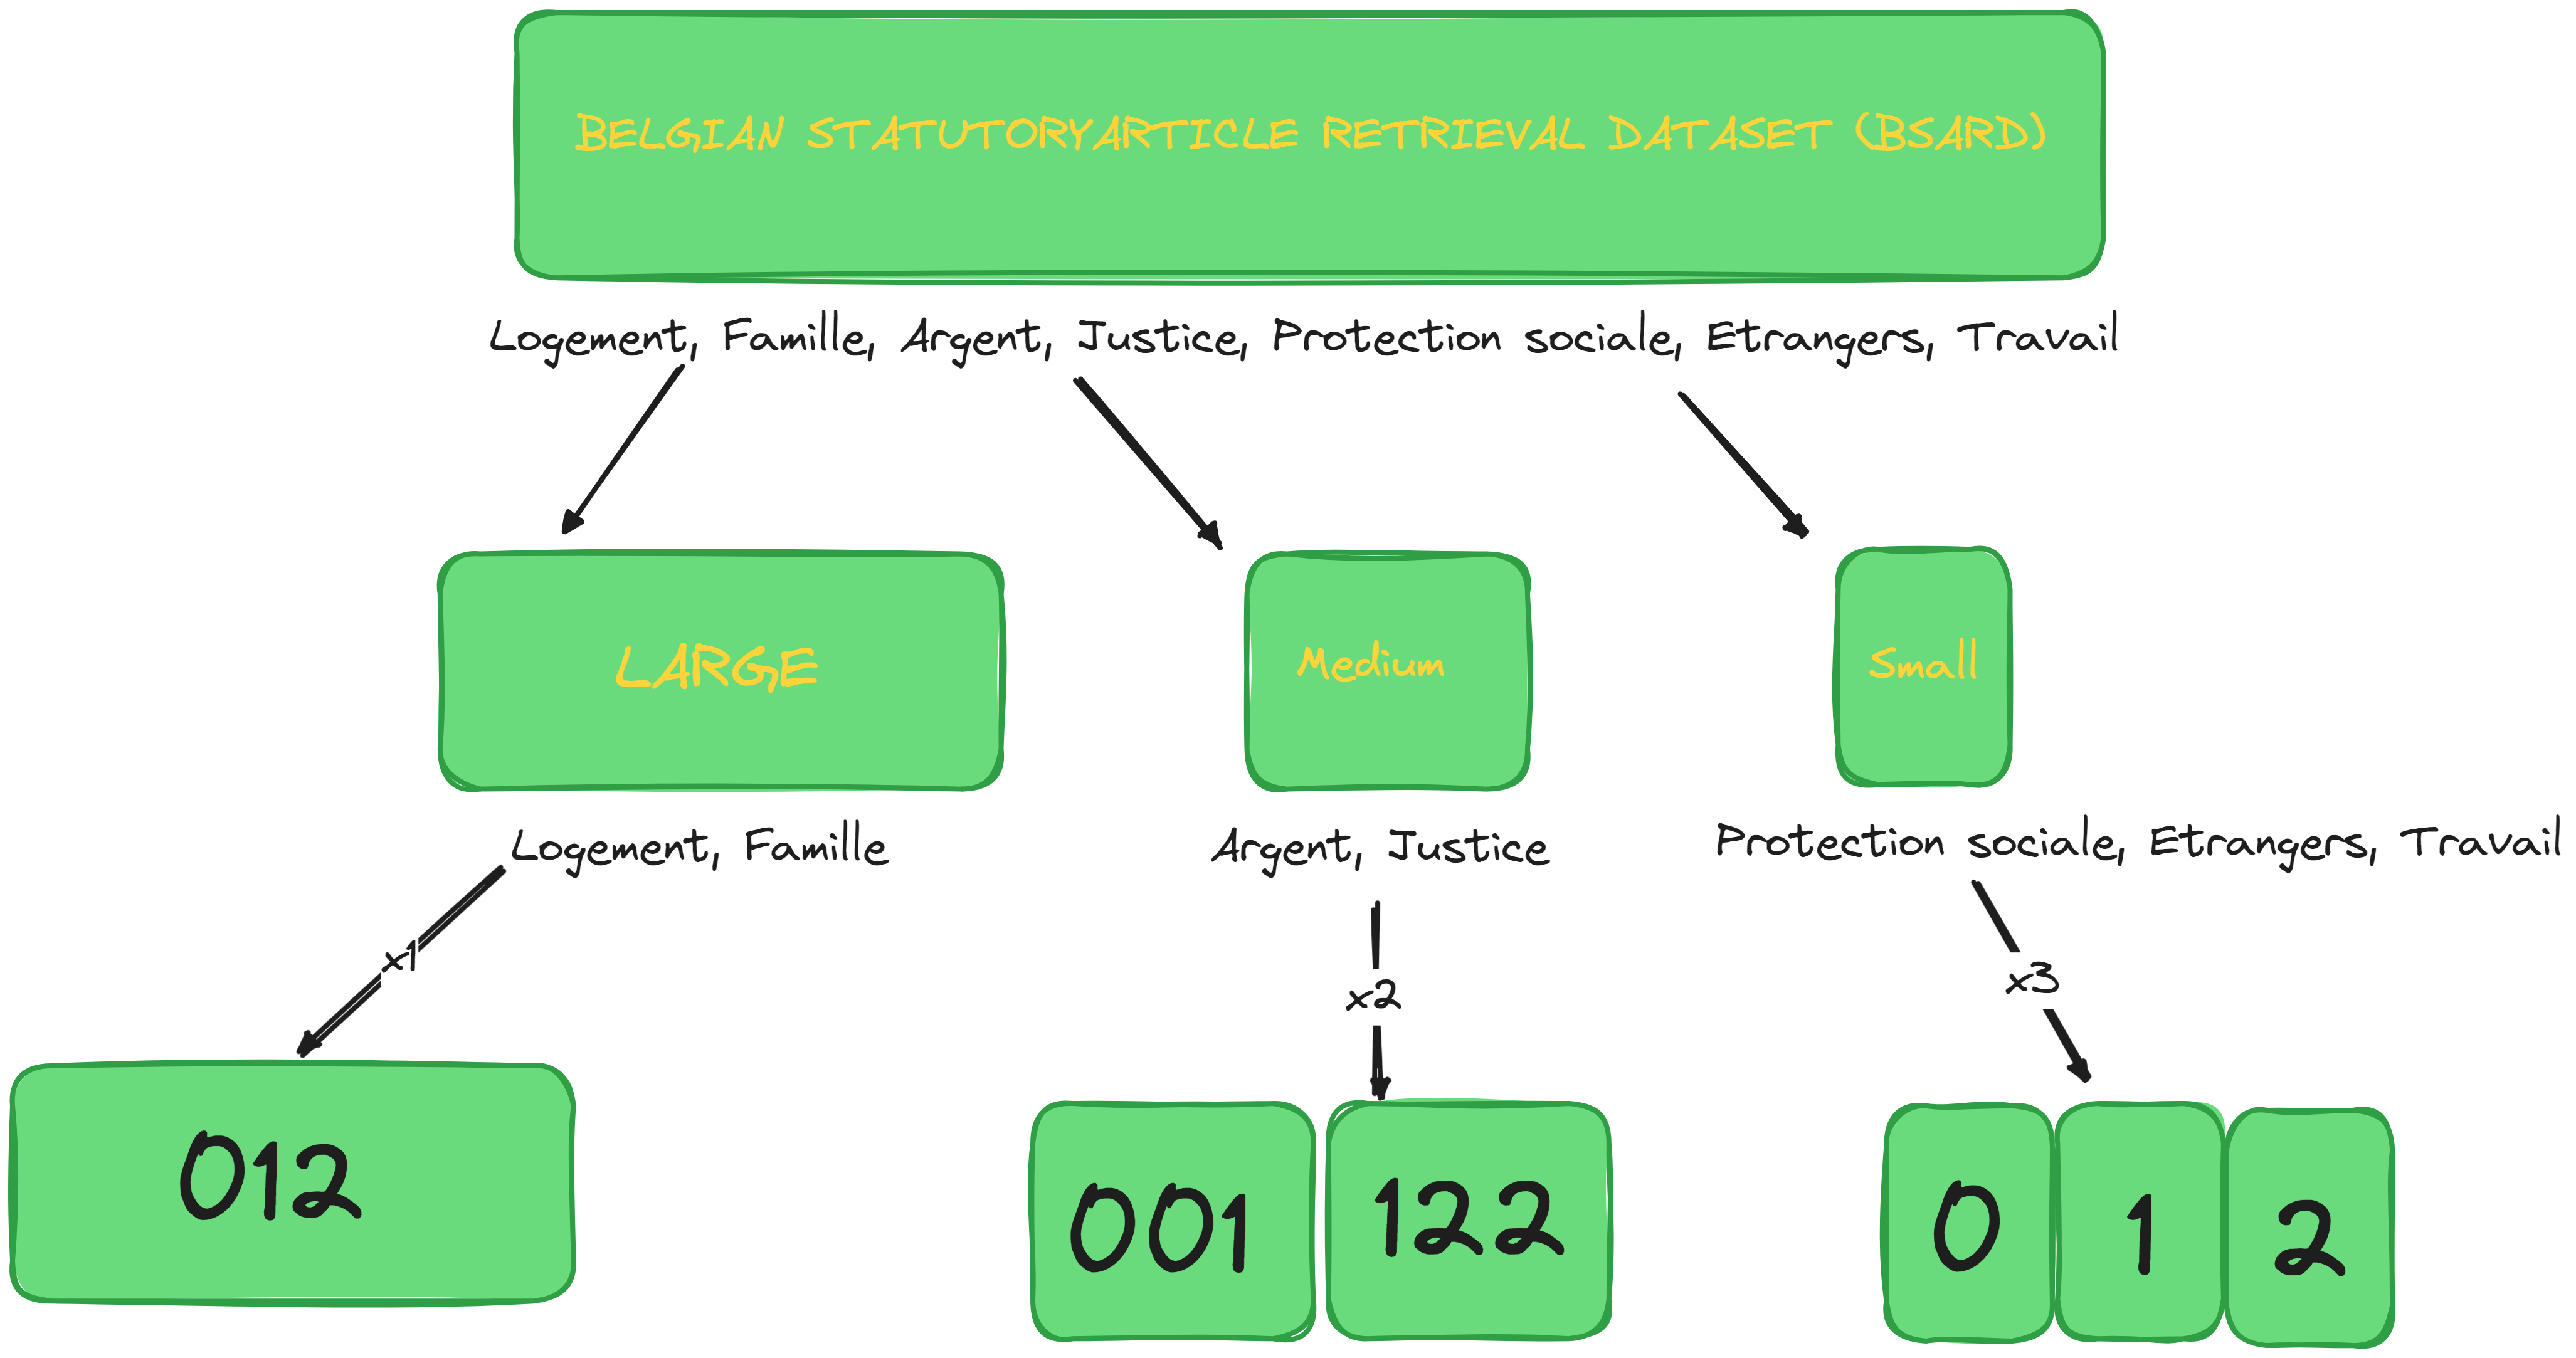

# **Data Exploration**

As i said earlier, for this project we'll only need two features from the original dataset which are: "questions" and "category" so we'll expore them a bit.

<ipython-input-31-50d4f5e88a10>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data["category"], palette="husl")


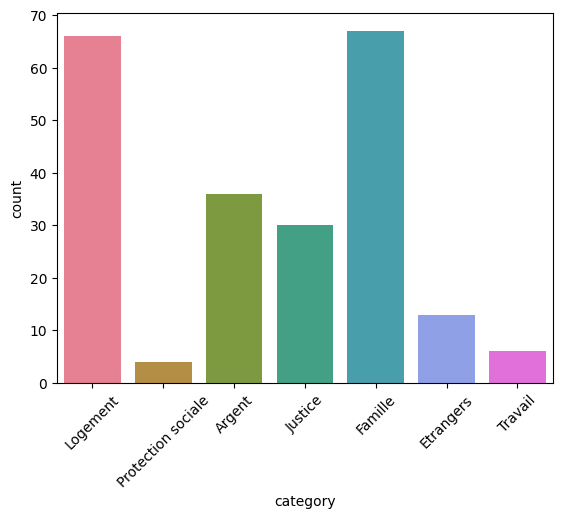

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

data = pd.read_csv("/content/questions_test.csv")

sns.countplot(x=data["category"], palette="husl")
plt.xticks(rotation=45)
plt.show()

In [ ]:
data["category"].value_counts(normalize=True)

Famille               0.301802
Logement              0.297297
Argent                0.162162
Justice               0.135135
Etrangers             0.058559
Travail               0.027027
Protection sociale    0.018018
Name: category, dtype: float64

The first problem we're encoutering is the inbalance of the "category" feature which we will use to generate our hypothesis, and since we're in a NLI/zero-shot problem, this feature represents our "hidden" classes and therefore, it should be important to try and balance them to make sure our model can generalize and learn to classify each class.

**Hypothesis**: we see that the *Logement* and *Family* categories are the most present while on the other hand we have the oppsite for *Protection sociale*, *Etrangers* and *Travail*. *Justice* and *Argent* are somehow in the middle.
So the strategy is:

* *Logement* and *Family*: since these have too many instances/questions, we'll slice them in 3 and give each third a label: 0 for Entailement, 1 for Nautrality and 2 for contradiction. After doing this, this part of the dataset will remain the same size.

* *Protection sociale*, *Etrangers* and *Travail*: these are the categories with the lowest number of questions, and therefore we'll triple them and give each copy a label 0, 1 and 2.

* *Justice* and *Argent*: The are the ones that don't have high instance requency and not a low one either, so we'll double them this way: we'll slice them into three parts, and we'll double each part and then we'll end up with 3 * 2*1/3, we'll give each pair of 1/3 labels: 1st pair (0, 1), 2nd pair (0, 2) and third pair (1, 2) this way we ensure this part i doubled.

In [ ]:
large = data[(data["category"] == "Famille") | (data["category"] == "Logement")]

In [ ]:
large.head()

,id,category,subcategory,question,extra_description,article_ids
0,775,Logement,Insalubrité en Wallonie,Quels sont les critères communaux d'insalubrité ?,NaN,12024
3,861,Logement,Location à Bruxelles,Comment se déroule une expulsion à Bruxelles ?,"Bail de résidence principale (Bruxelles), Fin ...","5562,5563,5564,5565,5566"
4,786,Logement,Location en Wallonie,Peut-on m'expulser en hiver en Wallonie ?,"Bail de résidence principale (Wallonie), Fin e...","5561,5562,5563,5564,5565,5566,5567,12124"
6,499,Famille,Situation de couples,Je vis en union libre. Quels sont les droits d...,Union libre,"944,945,946,947,948,949,950,951,1093,1094,1095..."
8,304,Famille,Lien parents/enfants,Le juge de paix peut-il refuser le choix du tu...,"Tutelle, Désignation du tuteur","1308,1310"


In [ ]:
medium = data[(data["category"] == "Argent") | (data["category"] == "Justice")]
medium.head()

,id,category,subcategory,question,extra_description,article_ids
2,72,Argent,Dettes,Quels frais peut-on ajouter lors d'un recouvre...,"Procédures de récupération des dettes, Récupér...","2041,2119,2138"
5,634,Justice,Infractions,"Si j’ai commis une infraction, peut-on me prop...","Amendes pénales, Paiement de l'amende pénale s...",13520
7,116,Argent,Dettes,Le règlement collectif de dettes suspend-il le...,"Solutions pour lutter contre l'endettement, Rè...",5961
10,635,Justice,Infractions,A partir de quel moment commence le délai de p...,"Amendes pénales, Prescription des amendes pénales","6163,6164,6165,6928,6935,6936"
12,724,Justice,Petite délinquance,La police peut-elle me fouiller pour chercher ...,"Détenir, acheter et vendre du cannabis",13348


In [ ]:
small = data[(data["category"] == "Travail") | (data["category"] == "Protection sociale") | (data["category"] == "Etrangers")]
small.head()

,id,category,subcategory,question,extra_description,article_ids
1,1053,Protection sociale,Grossesse et naissance,A-t-on droit à l'allocation de naissance en ca...,Allocations familiales et allocation de naissa...,"947,948"
14,228,Etrangers,Nationalité belge,Je suis majeur. Je suis né en Belgique. Puis-j...,NaN,18761
42,1093,Travail,Secret professionnel,Je me confie à un professionnel. Est-ce que to...,NaN,"945,6464,6617"
53,201,Etrangers,Etrangers et famille,Je vis avec ma famille en Belgique. Je me mari...,Mariage,1032
78,215,Etrangers,Nationalité belge,Je suis majeur. Je séjourne en Belgique depuis...,NaN,18761


In [ ]:
large.dropna(inplace=True)
medium.dropna(inplace=True)
small.dropna(inplace=True)

large.reset_index(drop=True, inplace=True)
medium.reset_index(drop=True, inplace=True)
small.reset_index(drop=True, inplace=True)

<ipython-input-37-7ef98b3ebcc5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  large.dropna(inplace=True)
<ipython-input-37-7ef98b3ebcc5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medium.dropna(inplace=True)
<ipython-input-37-7ef98b3ebcc5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small.dropna(inplace=True)


In [ ]:
large = large[["question", "category"]]
medium = medium[["question", "category"]]
small = small[["question", "category"]]

large

,question,category
0,Comment se déroule une expulsion à Bruxelles ?,Logement
1,Peut-on m'expulser en hiver en Wallonie ?,Logement
2,Je vis en union libre. Quels sont les droits d...,Famille
3,Le juge de paix peut-il refuser le choix du tu...,Famille
4,Qui concrètement gère le budget de la personne...,Famille
...,...,...
122,Puis-je changer de personne de confiance ou me...,Famille
123,Je deviens cohabitant légal. Dois-je payer les...,Famille
124,Je suis marié(e). On prend un logement en loca...,Famille
125,Est-ce que je peux signer plusieurs baux de co...,Logement


In [ ]:
len(large)

127

In [ ]:

ent = large.iloc[:len(large)//3]
cont = large.iloc[len(large)//3:len(large)*2//3]
neut = large.iloc[len(large)*2//3:]


In [ ]:
categories = list(set(data["category"].to_list()))
categories

['Travail',
 'Logement',
 'Protection sociale',
 'Etrangers',
 'Argent',
 'Famille',
 'Justice']

In [ ]:
ent["hypothèse"] = ent["category"].map(lambda category: "la question concerne la catégorie " + category)
ent["label"] = 0
ent["premisse"] = ent["question"]
ent = ent[["premisse", "hypothèse", "label"]]
ent.head()

<ipython-input-42-ffef3b1961e2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ent["hypothèse"] = ent["category"].map(lambda category: "la question concerne la catégorie " + category)
<ipython-input-42-ffef3b1961e2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ent["label"] = 0
<ipython-input-42-ffef3b1961e2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

,premisse,hypothèse,label
0,Comment se déroule une expulsion à Bruxelles ?,la question concerne la catégorie Logement,0
1,Peut-on m'expulser en hiver en Wallonie ?,la question concerne la catégorie Logement,0
2,Je vis en union libre. Quels sont les droits d...,la question concerne la catégorie Famille,0
3,Le juge de paix peut-il refuser le choix du tu...,la question concerne la catégorie Famille,0
4,Qui concrètement gère le budget de la personne...,la question concerne la catégorie Famille,0


In [ ]:
cont["hypothèse"] = cont["category"].map(lambda category: "la question ne concerne pas la catégorie " + category)
cont["label"] = 2
cont["premisse"] = cont["question"]
cont = cont[["premisse", "hypothèse", "label"]]
cont.head()

<ipython-input-43-3275b1bcc465>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cont["hypothèse"] = cont["category"].map(lambda category: "la question ne concerne pas la catégorie " + category)
<ipython-input-43-3275b1bcc465>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cont["label"] = 2
<ipython-input-43-3275b1bcc465>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

,premisse,hypothèse,label
42,Je n’ai pas choisi un contrat de bail étudiant...,la question ne concerne pas la catégorie Logement,2
43,Puis-je demander une diminution du loyer en co...,la question ne concerne pas la catégorie Logement,2
44,"Je me sépare. En tant que cohabitants légaux, ...",la question ne concerne pas la catégorie Famille,2
45,L’état des lieux est-il obligatoire à Bruxelles ?,la question ne concerne pas la catégorie Logement,2
46,L'enfant peut-il décider seul chez quel parent...,la question ne concerne pas la catégorie Famille,2


In [ ]:
import numpy as np

def replace_with_random_category(category, categories):
    categories_array = np.array(categories)
    other_categories = categories_array[categories_array != category].ravel()

    # Select a random different category
    random_category = np.random.choice(other_categories, 1)[0]

    return "la question concerne la catégorie " + random_category

neut["hypothèse"] = neut["category"].map(lambda category: replace_with_random_category(category, categories))
neut["label"] = 1
neut["premisse"] = neut["question"]
neut = neut[["premisse", "hypothèse", "label"]]
neut.head()

<ipython-input-44-53e14bdf38fb>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neut["hypothèse"] = neut["category"].map(lambda category: replace_with_random_category(category, categories))
<ipython-input-44-53e14bdf38fb>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neut["label"] = 1
<ipython-input-44-53e14bdf38fb>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

,premisse,hypothèse,label
84,Y'a-t-il un montant maximum pour la garantie l...,la question concerne la catégorie Argent,1
85,Les père et mère de l'enfant résident séparéme...,la question concerne la catégorie Etrangers,1
86,J'ai signé une déclaration de cohabitation lég...,la question concerne la catégorie Travail,1
87,Je divorce. En tant que victime de violences c...,la question concerne la catégorie Etrangers,1
88,Je suis marié(e). Dois-je payer les dettes pro...,la question concerne la catégorie Argent,1


In [ ]:
large = pd.concat([ent, cont, neut])
large

,premisse,hypothèse,label
0,Comment se déroule une expulsion à Bruxelles ?,la question concerne la catégorie Logement,0
1,Peut-on m'expulser en hiver en Wallonie ?,la question concerne la catégorie Logement,0
2,Je vis en union libre. Quels sont les droits d...,la question concerne la catégorie Famille,0
3,Le juge de paix peut-il refuser le choix du tu...,la question concerne la catégorie Famille,0
4,Qui concrètement gère le budget de la personne...,la question concerne la catégorie Famille,0
...,...,...,...
122,Puis-je changer de personne de confiance ou me...,la question concerne la catégorie Logement,1
123,Je deviens cohabitant légal. Dois-je payer les...,la question concerne la catégorie Protection s...,1
124,Je suis marié(e). On prend un logement en loca...,la question concerne la catégorie Etrangers,1
125,Est-ce que je peux signer plusieurs baux de co...,la question concerne la catégorie Justice,1


In [ ]:
medium.shape[0]

64

In [ ]:
med10 = medium.iloc[:22].copy()
med11 = medium.iloc[:22].copy()
med20 = medium.iloc[22:43].copy()
med22 = medium.iloc[22:43].copy()
med31 = medium.iloc[43:64].copy()
med32 = medium.iloc[43:64].copy()

In [ ]:
med10["label"] = 0
med11["label"] = 1
med20["label"] = 0
med22["label"] = 2
med31["label"] = 1
med32["label"] = 2

In [ ]:
doubled_medium = pd.concat([med10, med11, med20, med22, med31, med32])
doubled_medium.reset_index(drop=True, inplace=True)

# Continue with the code
for index, row in doubled_medium.iterrows():
  if row["label"] == 0:
    doubled_medium.loc[index, "hypothèse"] = "la question concerne la catégorie " + row["category"]
  elif row["label"] == 2:
    doubled_medium.loc[index, "hypothèse"] = "la question ne concerne pas la catégorie " + row["category"]
  else:
    doubled_medium.loc[index, "hypothèse"] = replace_with_random_category(row["category"], categories)

doubled_medium["premisse"] = doubled_medium.loc[:,"question"]
doubled_medium = doubled_medium[["premisse", "hypothèse", "label"]]


In [ ]:
doubled_medium

,premisse,hypothèse,label
0,Quels frais peut-on ajouter lors d'un recouvre...,la question concerne la catégorie Argent,0
1,"Si j’ai commis une infraction, peut-on me prop...",la question concerne la catégorie Justice,0
2,Le règlement collectif de dettes suspend-il le...,la question concerne la catégorie Argent,0
3,A partir de quel moment commence le délai de p...,la question concerne la catégorie Justice,0
4,La police peut-elle me fouiller pour chercher ...,la question concerne la catégorie Justice,0
...,...,...,...
123,La peine de travail est-elle rémunérée ?,la question ne concerne pas la catégorie Justice,2
124,Je suis convoqué en justice. Qu'est-ce qu'une ...,la question ne concerne pas la catégorie Justice,2
125,Puis-je avoir une aide pour payer les frais de...,la question ne concerne pas la catégorie Justice,2
126,Quels sont les recours contre une décision d'a...,la question ne concerne pas la catégorie Argent,2


In [ ]:
small.shape[0]

8

In [ ]:
tripled_small = pd.concat([small, small, small])

In [ ]:
tripled_small.reset_index(drop=True, inplace=True)

In [ ]:
tripled_small

,question,category
0,A-t-on droit à l'allocation de naissance en ca...,Protection sociale
1,Je vis avec ma famille en Belgique. Je me mari...,Etrangers
2,Je reçois les confidences en tant que professi...,Travail
3,Devant quel tribunal introduire le recours con...,Protection sociale
4,Puis-je m'absenter du travail pour aller chez ...,Travail
5,Puis-je introduire un recours en urgence ?,Protection sociale
6,Je suis majeur. Je suis handicapé . Puis-je in...,Etrangers
7,Je suis travailleur salarié(e). Quand dois-je ...,Travail
8,A-t-on droit à l'allocation de naissance en ca...,Protection sociale
9,Je vis avec ma famille en Belgique. Je me mari...,Etrangers


In [ ]:
tripled_small.loc[:8,"label"] = 0
tripled_small.loc[8:16,"label"] = 1
tripled_small.loc[16:24,"label"] = 2

In [ ]:
tripled_small.index

RangeIndex(start=0, stop=24, step=1)

In [ ]:
for index, row in tripled_small.iterrows():
  if row["label"] == 0:
    tripled_small.loc[index, "hypothèse"] = "la question concerne la catégorie " + row["category"]
  elif row["label"] == 2:
    tripled_small.loc[index, "hypothèse"] = "la question ne concerne pas la catégorie " + row["category"]
  else:
   tripled_small.loc[index, "hypothèse"] = replace_with_random_category(row["category"], categories)

tripled_small["premisse"] = tripled_small.loc[:,"question"]
tripled_small = tripled_small[["premisse", "hypothèse", "label"]]

In [ ]:
tripled_small

,premisse,hypothèse,label
0,A-t-on droit à l'allocation de naissance en ca...,la question concerne la catégorie Protection s...,0.0
1,Je vis avec ma famille en Belgique. Je me mari...,la question concerne la catégorie Etrangers,0.0
2,Je reçois les confidences en tant que professi...,la question concerne la catégorie Travail,0.0
3,Devant quel tribunal introduire le recours con...,la question concerne la catégorie Protection s...,0.0
4,Puis-je m'absenter du travail pour aller chez ...,la question concerne la catégorie Travail,0.0
5,Puis-je introduire un recours en urgence ?,la question concerne la catégorie Protection s...,0.0
6,Je suis majeur. Je suis handicapé . Puis-je in...,la question concerne la catégorie Etrangers,0.0
7,Je suis travailleur salarié(e). Quand dois-je ...,la question concerne la catégorie Travail,0.0
8,A-t-on droit à l'allocation de naissance en ca...,la question concerne la catégorie Logement,1.0
9,Je vis avec ma famille en Belgique. Je me mari...,la question concerne la catégorie Famille,1.0


In [ ]:
new_data = pd.concat([large, doubled_medium, tripled_small])
new_data['label'] = new_data['label'].astype(int)
new_data.reset_index(drop=True, inplace=True)
new_data

,premisse,hypothèse,label
0,Comment se déroule une expulsion à Bruxelles ?,la question concerne la catégorie Logement,0
1,Peut-on m'expulser en hiver en Wallonie ?,la question concerne la catégorie Logement,0
2,Je vis en union libre. Quels sont les droits d...,la question concerne la catégorie Famille,0
3,Le juge de paix peut-il refuser le choix du tu...,la question concerne la catégorie Famille,0
4,Qui concrètement gère le budget de la personne...,la question concerne la catégorie Famille,0
...,...,...,...
274,Devant quel tribunal introduire le recours con...,la question ne concerne pas la catégorie Prote...,2
275,Puis-je m'absenter du travail pour aller chez ...,la question ne concerne pas la catégorie Travail,2
276,Puis-je introduire un recours en urgence ?,la question ne concerne pas la catégorie Prote...,2
277,Je suis majeur. Je suis handicapé . Puis-je in...,la question ne concerne pas la catégorie Etran...,2


In [ ]:
new_data.to_csv('/content/new_data_test.csv')


 Now that we gave our new transformed and augmented dataset we'll now visualize the WORDCLOUD

In [ ]:
%env TOKENIZERS_PARALLELISM=true
! pip install sentence-transformers

env: TOKENIZERS_PARALLELISM=true
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 4.1 MB/s eta 0:00:00


In [ ]:
!pip install Pillow

(-0.5, 1199.5, 1199.5, -0.5)

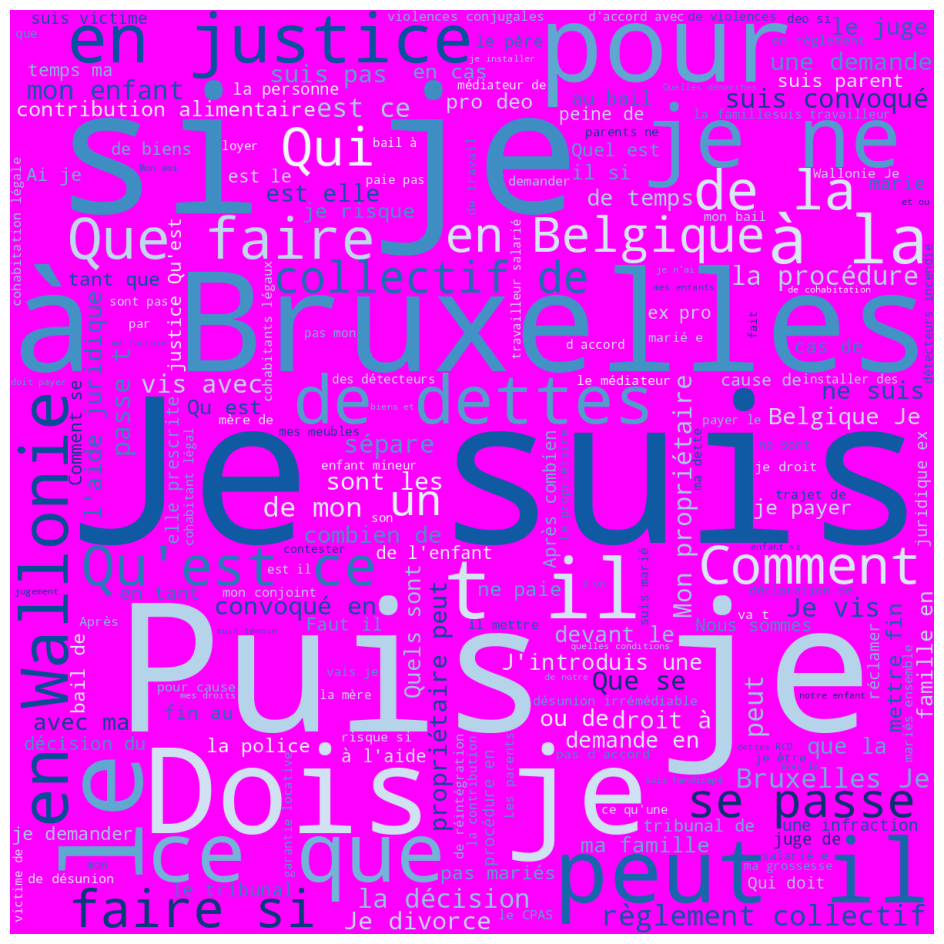

In [ ]:
from matplotlib.pyplot import subplots
from matplotlib.pyplot import axis
from matplotlib.pyplot import imshow
from wordcloud import WordCloud
from wordcloud import STOPWORDS

FRACTION = 1.0
subplots(figsize=(12, 12))
text = ' '.join(new_data.sample(frac=FRACTION, random_state=2023)['premisse'].values.tolist())
imshow(X=WordCloud(random_state=2023, height=1200, width=1200, stopwords=STOPWORDS, background_color="#FF00FF", colormap='Blues').generate(text=text), )
axis('off')

# **Colclusion**

In this notebook i did only one hypothesis for this dataset which is to use the categories to transform the BSARD dataset into an NLI one, while we can also try and create hypothesis using also sub categories of each question where we have to use One-hot encoding etc.

We can now use our new dataset to finetune a pretrained model for a zero-shot classification task.